In [16]:
import librosa
import torch
import pickle
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [2]:
df_standart = pd.read_csv('standart_data.csv', index_col=0)

In [3]:
def age_groups(age):
    if age < 25:
        return 'young'
    elif 40 < age < 46:
        return 'middle'
    else:
        return 'elderly'

In [4]:
df_standart['age_group'] = df_standart['age'].apply(age_groups)
df_standart = df_standart.sample(frac=1)

In [5]:
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name, device='cuda')
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.bias', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_q.weight', 'quantizer.codevectors', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
files_standart = list(df_standart['filename'])
df_standart

,informant,start,end,filename,corpus,text,gender,age,age_group
Sib_05-m_59.95_61.43,Sib_05-m,59.95,61.43,./trimmed/Sib_05-m_59.95_61.43.wav,standart,"∙∙∙ заехали в лес,",m,22,young
Sib_17-m_249.54_251.55,Sib_17-m,249.54,251.55,./trimmed/Sib_17-m_249.54_251.55.wav,standart,∙∙∙ А ещё фро-онт!,m,70,elderly
Sib_10-m_17.9_18.44,Sib_10-m,17.90,18.44,./trimmed/Sib_10-m_17.9_18.44.wav,standart,"невесту,",m,44,middle
Sib_15-f_180.97_182.19,Sib_15-f,180.97,182.19,./trimmed/Sib_15-f_180.97_182.19.wav,standart,"что лёд уже-е ∙∙ тронулся,",f,70,elderly
Sib_17-m_46.52_48.56,Sib_17-m,46.52,48.56,./trimmed/Sib_17-m_46.52_48.56.wav,standart,"— Ро= ‖ эээ ла= ‖ ээ нашей страны,",m,70,elderly
...,...,...,...,...,...,...,...,...,...
Sib_08-f_95.88_98.46,Sib_08-f,95.88,98.46,./trimmed/Sib_08-f_95.88_98.46.wav,standart,∙∙∙ Очень много было смешных историй.,f,48,elderly
Sib_01-f_100.64_102.92,Sib_01-f,100.64,102.92,./trimmed/Sib_01-f_100.64_102.92.wav,standart,∙∙∙∙ ээ мы пришли в ==,f,19,young
Sib_07-f_101.93_104.4,Sib_07-f,101.93,104.40,./trimmed/Sib_07-f_101.93_104.4.wav,standart,"там идеально ровные по диаметру вот эти озёра,",f,42,middle
Sib_07-f_49.06_50.41,Sib_07-f,49.06,50.41,./trimmed/Sib_07-f_49.06_50.41.wav,standart,"∙∙∙ Постояли,,,",f,42,middle


In [7]:
df_standart['difference'] = (df_standart['end']*1000 -  df_standart['start']*1000)

In [8]:
timing = (sum(df_standart['difference'])/1000)/60
print(timing)

40.78066666666667


In [9]:
df_standart[df_standart['age'] == '2']

,informant,start,end,filename,corpus,text,gender,age,age_group,difference


In [10]:
massivix_st = []
for i in tqdm(files_standart):
    input_audio, sample_rate = librosa.load(i,  sr=16000)
    massivix_st.append(input_audio)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [11]:
vectors_st = feature_extractor(massivix_st, return_tensors="pt", sampling_rate=sample_rate, padding='max_length', 
                    max_length=2620, truncation=True).input_values

In [24]:
torch.save(vectors_st, 'vectors_st.pth')

In [25]:
vectors = torch.load('vectors_st.pth', map_location=torch.device('cpu'))

In [17]:
class VectorsDataset(Dataset):
    def __init__(self, X, paths):
        self.X = torch.tensor(X)
        self.paths = paths
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.paths[idx]

In [19]:
dataset = VectorsDataset(X=vectors_st, paths=files_standart)

/tmp/ipykernel_87990/832104874.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


In [20]:
dataloader = DataLoader(dataset, 64, True)

In [21]:
! rm -r predictions

In [22]:
!mkdir predictions

In [23]:
path2vec = {}
for vector, paths in tqdm(dataloader):
    predict = model(vector.to('cpu')).extract_features
    for i in range(len(predict)):
        filename = 'predictions/' + paths[i].replace('.wav', '.pth').replace('/', '_')
        torch.save(predict[i], filename)
        path2vec[paths[i]] = filename
        # print(predict[i].shape)


  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
with open('data_standart.pickle', 'wb') as f:
     pickle.dump(path2vec, f)

with open('data_standart.pickle', 'rb') as f:
     path2vec = pickle.load(f)

In [24]:
items = path2vec.items()

In [25]:
X = []
Y = []
for item in tqdm(items):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['gender'].to_list()[0]
    X.append(sum(np.array(vector)))
    Y.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [28]:
len(X_test)

246

In [124]:
def accuracy(dct, y_test, y_pred):
    total = len(y_test)
    count = 0
    for i in range(len(y_test)):
        dct[y_test[i]][y_pred[i]] += 1

    return dct

In [156]:
dct1 = {
    'm': {
        'm': 0,
        'f': 0,
    },
    'f': {
        'm': 0,
        'f': 0,
    }
}

In [29]:
!pip install --upgrade pip

In [30]:
!pip install catboost==1.1.1

In [29]:
train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=1000)
model.fit(train_data, train_labels, eval_set=(X_val, y_val))

Learning rate set to 0.029378
0:	learn: 0.6691655	test: 0.6742994	best: 0.6742994 (0)	total: 70.1ms	remaining: 1m 9s
1:	learn: 0.6474250	test: 0.6559013	best: 0.6559013 (1)	total: 86.5ms	remaining: 43.2s
2:	learn: 0.6295028	test: 0.6394227	best: 0.6394227 (2)	total: 103ms	remaining: 34.3s
3:	learn: 0.6136584	test: 0.6249755	best: 0.6249755 (3)	total: 119ms	remaining: 29.8s
4:	learn: 0.6004223	test: 0.6151953	best: 0.6151953 (4)	total: 137ms	remaining: 27.2s
5:	learn: 0.5860432	test: 0.6074749	best: 0.6074749 (5)	total: 153ms	remaining: 25.3s
6:	learn: 0.5711971	test: 0.5953677	best: 0.5953677 (6)	total: 171ms	remaining: 24.3s
7:	learn: 0.5579457	test: 0.5860318	best: 0.5860318 (7)	total: 188ms	remaining: 23.3s
8:	learn: 0.5405556	test: 0.5704158	best: 0.5704158 (8)	total: 204ms	remaining: 22.5s
9:	learn: 0.5255372	test: 0.5611344	best: 0.5611344 (9)	total: 221ms	remaining: 21.9s
10:	learn: 0.5122375	test: 0.5522036	best: 0.5522036 (10)	total: 237ms	remaining: 21.3s
11:	learn: 0.4990073

In [153]:
import itertools

In [30]:
y_pred = model.predict(X_test)

In [157]:
accuracy(dct1, y_test, list(itertools.chain.from_iterable(y_pred.tolist())))

{'m': {'m': 114, 'f': 6}, 'f': {'m': 12, 'f': 114}}

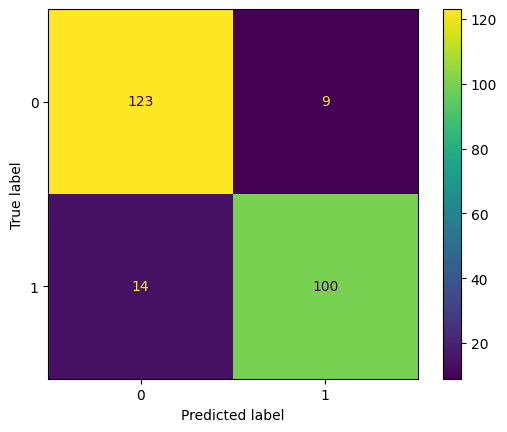

In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [36]:
from sklearn.metrics import f1_score, accuracy_score

In [32]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, pos_label='f'), sep='\n')

0.9065040650406504
0.9144981412639405


In [33]:
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                      random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)


Iteration 1, loss = 5.96970101
Iteration 2, loss = 2.54407559
Iteration 3, loss = 1.66772268
Iteration 4, loss = 1.20788425
Iteration 5, loss = 1.10858756
Iteration 6, loss = 0.73211109
Iteration 7, loss = 0.55818636
Iteration 8, loss = 0.35551509
Iteration 9, loss = 0.33318096
Iteration 10, loss = 0.25320094
Iteration 11, loss = 0.19799050
Iteration 12, loss = 0.15459486
Iteration 13, loss = 0.14886181
Iteration 14, loss = 0.13905351
Iteration 15, loss = 0.08753923
Iteration 16, loss = 0.08058105
Iteration 17, loss = 0.07180966
Iteration 18, loss = 0.06277058
Iteration 19, loss = 0.05370346
Iteration 20, loss = 0.05058919
Iteration 21, loss = 0.04823362
Iteration 22, loss = 0.04325892
Iteration 23, loss = 0.04269690
Iteration 24, loss = 0.03951673
Iteration 25, loss = 0.04129829
Iteration 26, loss = 0.03344293
Iteration 27, loss = 0.02972201
Iteration 28, loss = 0.02829914
Iteration 29, loss = 0.02655630
Iteration 30, loss = 0.02464779
Iteration 31, loss = 0.02416232
Iteration 32, los

0.9308943089430894

## Возраст

In [47]:
X = []
Y = []
for item in tqdm(items):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['age_group'].to_list()[0]
    X.append(sum(np.array(vector)))
    Y.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

In [105]:
y_pred = model.predict(X_test)

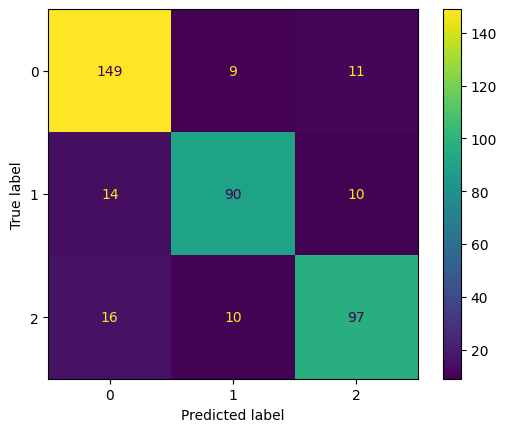

In [106]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [107]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

0.8275862068965517
0.8228253266949567


In [48]:
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)


Iteration 1, loss = 11.32415161
Iteration 2, loss = 5.06602217
Iteration 3, loss = 2.37027364
Iteration 4, loss = 1.71516229
Iteration 5, loss = 1.18785006
Iteration 6, loss = 0.76210973
Iteration 7, loss = 0.67522358
Iteration 8, loss = 0.69673630
Iteration 9, loss = 0.60796468
Iteration 10, loss = 0.47587965
Iteration 11, loss = 0.29969652
Iteration 12, loss = 0.29690906
Iteration 13, loss = 0.18442636
Iteration 14, loss = 0.19507862
Iteration 15, loss = 0.18620074
Iteration 16, loss = 0.16874624
Iteration 17, loss = 0.23474481
Iteration 18, loss = 0.15226953
Iteration 19, loss = 0.15211016
Iteration 20, loss = 0.09101036
Iteration 21, loss = 0.08532341
Iteration 22, loss = 0.09269381
Iteration 23, loss = 0.08570901
Iteration 24, loss = 0.08866729
Iteration 25, loss = 0.10267838
Iteration 26, loss = 0.11381226
Iteration 27, loss = 0.07432966
Iteration 28, loss = 0.06484637
Iteration 29, loss = 0.05271997
Iteration 30, loss = 0.05093258
Iteration 31, loss = 0.04470851
Iteration 32, lo

0.8103448275862069

## Fine-tuned model

In [37]:
model_name_ft = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
feature_extractor_ft = Wav2Vec2FeatureExtractor.from_pretrained(model_name_ft, device='cuda')
model_ft = Wav2Vec2Model.from_pretrained(model_name_ft)

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-russian were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
vectors_st_ft = feature_extractor_ft(massivix_st, return_tensors="pt", sampling_rate=sample_rate, padding='max_length', 
         
                                     max_length=2620, truncation=True).input_values

In [11]:
torch.save(vectors_st_ft, 'vectors_st_ft.pth')

In [12]:
vectors_st_ft = torch.load('vectors_st_ft.pth', map_location=torch.device('cpu'))

In [50]:
dataset_ft = VectorsDataset(X=vectors_st_ft, paths=files_standart)

/tmp/ipykernel_87990/832104874.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


In [51]:
dataloader = DataLoader(dataset_ft, 64, True)

In [52]:
!rm -r predictions_ft

In [53]:
!mkdir predictions_ft

In [55]:
path2vec = {}
for vector_ent, paths in tqdm(dataloader):
    predict = model_ft(vector_ent.to('cpu')).extract_features
    for i in range(len(predict)):
        filename = 'predictions_ft/' + paths[i].replace('.wav', '.pth').replace('/', '_')
        torch.save(predict[i], filename)
        path2vec[paths[i]] = filename
        # print(predict[i].shape)


  0%|          | 0/20 [00:00<?, ?it/s]

In [159]:
import pickle

with open('data_standart_ft.pickle', 'wb') as f:
     pickle.dump(path2vec, f)

with open('data_standart_ft.pickle', 'rb') as f:
     path2vec = pickle.load(f)

In [56]:
items_ft = path2vec.items()

In [57]:
X_ft = []
Y_ft = []
for item in tqdm(items_ft):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['gender'].to_list()[0]
    X_ft.append(sum(np.array(vector)))
    Y_ft.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_ft, Y_ft, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

Learning rate set to 0.041451
0:	learn: 0.6586578	total: 71.7ms	remaining: 14.3s
1:	learn: 0.6345819	total: 88.5ms	remaining: 8.76s
2:	learn: 0.6123815	total: 105ms	remaining: 6.91s
3:	learn: 0.5887399	total: 122ms	remaining: 6s
4:	learn: 0.5696367	total: 139ms	remaining: 5.43s
5:	learn: 0.5546150	total: 157ms	remaining: 5.07s
6:	learn: 0.5388755	total: 174ms	remaining: 4.8s
7:	learn: 0.5224086	total: 192ms	remaining: 4.62s
8:	learn: 0.5051301	total: 210ms	remaining: 4.46s
9:	learn: 0.4911507	total: 228ms	remaining: 4.33s
10:	learn: 0.4757155	total: 246ms	remaining: 4.22s
11:	learn: 0.4590279	total: 262ms	remaining: 4.1s
12:	learn: 0.4455713	total: 279ms	remaining: 4.02s
13:	learn: 0.4263511	total: 296ms	remaining: 3.93s
14:	learn: 0.4168730	total: 314ms	remaining: 3.87s
15:	learn: 0.4062075	total: 331ms	remaining: 3.81s
16:	learn: 0.3964014	total: 348ms	remaining: 3.75s
17:	learn: 0.3899248	total: 366ms	remaining: 3.7s
18:	learn: 0.3823051	total: 385ms	remaining: 3.66s
19:	learn: 0.37

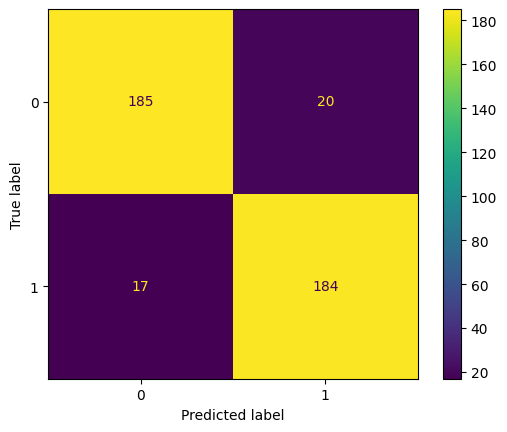

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [25]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, pos_label='f'), sep='\n')

0.9088669950738916
0.9090909090909092


In [58]:
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)

Iteration 1, loss = 11.32415161
Iteration 2, loss = 5.06602217
Iteration 3, loss = 2.37027364
Iteration 4, loss = 1.71516229
Iteration 5, loss = 1.18785006
Iteration 6, loss = 0.76210973
Iteration 7, loss = 0.67522358
Iteration 8, loss = 0.69673630
Iteration 9, loss = 0.60796468
Iteration 10, loss = 0.47587965
Iteration 11, loss = 0.29969652
Iteration 12, loss = 0.29690906
Iteration 13, loss = 0.18442636
Iteration 14, loss = 0.19507862
Iteration 15, loss = 0.18620074
Iteration 16, loss = 0.16874624
Iteration 17, loss = 0.23474481
Iteration 18, loss = 0.15226953
Iteration 19, loss = 0.15211016
Iteration 20, loss = 0.09101036
Iteration 21, loss = 0.08532341
Iteration 22, loss = 0.09269381
Iteration 23, loss = 0.08570901
Iteration 24, loss = 0.08866729
Iteration 25, loss = 0.10267838
Iteration 26, loss = 0.11381226
Iteration 27, loss = 0.07432966
Iteration 28, loss = 0.06484637
Iteration 29, loss = 0.05271997
Iteration 30, loss = 0.05093258
Iteration 31, loss = 0.04470851
Iteration 32, lo

0.8103448275862069

## Возраст

In [45]:
X_ft = []
Y_ft = []
for item in tqdm(items_ft):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['age_group'].to_list()[0]
    X_ft.append(sum(np.array(vector)))
    Y_ft.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_ft, Y_ft, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=600)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

Learning rate set to 0.120627
0:	learn: 1.0563471	total: 187ms	remaining: 1m 52s
1:	learn: 0.9999238	total: 319ms	remaining: 1m 35s
2:	learn: 0.9631509	total: 443ms	remaining: 1m 28s
3:	learn: 0.9266509	total: 608ms	remaining: 1m 30s
4:	learn: 0.8993445	total: 733ms	remaining: 1m 27s
5:	learn: 0.8692982	total: 864ms	remaining: 1m 25s
6:	learn: 0.8366091	total: 1.09s	remaining: 1m 32s
7:	learn: 0.8108971	total: 1.24s	remaining: 1m 31s
8:	learn: 0.7845535	total: 1.38s	remaining: 1m 30s
9:	learn: 0.7650679	total: 1.52s	remaining: 1m 29s
10:	learn: 0.7444446	total: 1.68s	remaining: 1m 29s
11:	learn: 0.7239316	total: 1.85s	remaining: 1m 30s
12:	learn: 0.7067215	total: 1.99s	remaining: 1m 29s
13:	learn: 0.6886642	total: 2.2s	remaining: 1m 32s
14:	learn: 0.6741766	total: 2.37s	remaining: 1m 32s
15:	learn: 0.6593165	total: 2.53s	remaining: 1m 32s
16:	learn: 0.6455108	total: 2.68s	remaining: 1m 32s
17:	learn: 0.6324185	total: 2.85s	remaining: 1m 32s
18:	learn: 0.6215681	total: 3.02s	remaining: 

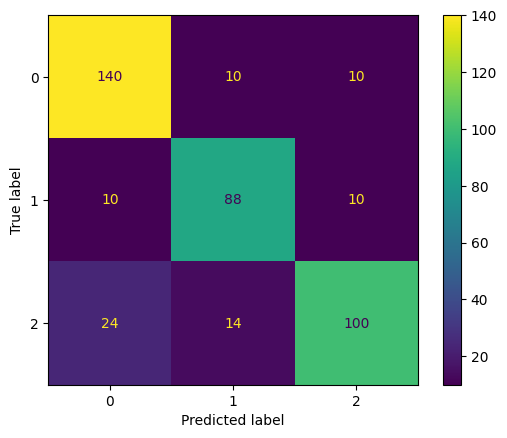

In [140]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [141]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

0.8078817733990148
0.8045057172476753


In [46]:
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)

Iteration 1, loss = 11.32415161
Iteration 2, loss = 5.06602217
Iteration 3, loss = 2.37027364
Iteration 4, loss = 1.71516229
Iteration 5, loss = 1.18785006
Iteration 6, loss = 0.76210973
Iteration 7, loss = 0.67522358
Iteration 8, loss = 0.69673630
Iteration 9, loss = 0.60796468
Iteration 10, loss = 0.47587965
Iteration 11, loss = 0.29969652
Iteration 12, loss = 0.29690906
Iteration 13, loss = 0.18442636
Iteration 14, loss = 0.19507862
Iteration 15, loss = 0.18620074
Iteration 16, loss = 0.16874624
Iteration 17, loss = 0.23474481
Iteration 18, loss = 0.15226953
Iteration 19, loss = 0.15211016
Iteration 20, loss = 0.09101036
Iteration 21, loss = 0.08532341
Iteration 22, loss = 0.09269381
Iteration 23, loss = 0.08570901
Iteration 24, loss = 0.08866729
Iteration 25, loss = 0.10267838
Iteration 26, loss = 0.11381226
Iteration 27, loss = 0.07432966
Iteration 28, loss = 0.06484637
Iteration 29, loss = 0.05271997
Iteration 30, loss = 0.05093258
Iteration 31, loss = 0.04470851
Iteration 32, lo

0.8103448275862069

## Layers_age

In [38]:
o = model(vectors_st, output_hidden_states=True)

In [39]:
maupennaya_age = torch.reshape(o['hidden_states'][0], (7*1024, 1228)).tolist()

In [31]:
ys = df_standart['age_group'].to_list()

In [29]:
def for_each(tensor, ys):
    X_train, X_test, y_train, y_test = train_test_split(tensor, ys, test_size=0.33, random_state=42)

    train_data = X_train
    train_labels = y_train

    model = CatBoostClassifier(iterations=200, task_type="GPU",
                           devices='0', verbose=False)
    model.fit(train_data, train_labels)

    y_pred = model.predict(X_test)
    f_score = f1_score(y_test, y_pred, average='macro')
    print(f_score)
    return f_score

In [45]:
results = {}
layers = o['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.7419556250462026
Result on layer 1: 0.7419556250462026
----------
LAYER: 2
0.7262285620067374
Result on layer 2: 0.7262285620067374
----------
LAYER: 3
0.7173426044393786
Result on layer 3: 0.7173426044393786
----------
LAYER: 4
0.691635538033843
Result on layer 4: 0.691635538033843
----------
LAYER: 5
0.6398179690076152
Result on layer 5: 0.6398179690076152
----------
LAYER: 6
0.6593887222528593
Result on layer 6: 0.6593887222528593
----------
LAYER: 7
0.6242575499587936
Result on layer 7: 0.6242575499587936
----------
LAYER: 8
0.6150290075662322
Result on layer 8: 0.6150290075662322
----------
LAYER: 9
0.6159961424034703
Result on layer 9: 0.6159961424034703
----------
LAYER: 10
0.587775849243739
Result on layer 10: 0.587775849243739
----------
LAYER: 11
0.610801531914659
Result on layer 11: 0.610801531914659
----------
LAYER: 12
0.6179747102769199
Result on layer 12: 0.6179747102769199
----------
LAYER: 13
0.6129506671625103
Result on layer 13: 0.6129506671625103
--------

In [46]:
results

{1: 0.7419556250462026,
 2: 0.7262285620067374,
 3: 0.7173426044393786,
 4: 0.691635538033843,
 5: 0.6398179690076152,
 6: 0.6593887222528593,
 7: 0.6242575499587936,
 8: 0.6150290075662322,
 9: 0.6159961424034703,
 10: 0.587775849243739,
 11: 0.610801531914659,
 12: 0.6179747102769199,
 13: 0.6129506671625103,
 14: 0.5801262612856816,
 15: 0.5908011252228734,
 16: 0.6043327819887551,
 17: 0.6174998293199131,
 18: 0.6149949446897559,
 19: 0.6494656810479477,
 20: 0.6509944412022349,
 21: 0.7280685900151508,
 22: 0.6733002212778513,
 23: 0.5550794823405364,
 24: 0.5818556887699012,
 25: 0.6615973726826867}

In [27]:
pauma_age = model_ft(vectors_st_ft, output_hidden_states=True)

In [32]:
results = {}
layers = pauma_age['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.7053295024800654
Result on layer 1: 0.7053295024800654
----------
LAYER: 2
0.7078831578201848
Result on layer 2: 0.7078831578201848
----------
LAYER: 3
0.7036576521957626
Result on layer 3: 0.7036576521957626
----------
LAYER: 4
0.708778328880261
Result on layer 4: 0.708778328880261
----------
LAYER: 5
0.661986726145142
Result on layer 5: 0.661986726145142
----------
LAYER: 6
0.6689360123018032
Result on layer 6: 0.6689360123018032
----------
LAYER: 7
0.6450298472053911
Result on layer 7: 0.6450298472053911
----------
LAYER: 8
0.6295205230187589
Result on layer 8: 0.6295205230187589
----------
LAYER: 9
0.6352097027478291
Result on layer 9: 0.6352097027478291
----------
LAYER: 10
0.6349222055883444
Result on layer 10: 0.6349222055883444
----------
LAYER: 11
0.6324125192845802
Result on layer 11: 0.6324125192845802
----------
LAYER: 12
0.59587845073281
Result on layer 12: 0.59587845073281
----------
LAYER: 13
0.6068575236969019
Result on layer 13: 0.6068575236969019
----------

In [33]:
results

{1: 0.7053295024800654,
 2: 0.7078831578201848,
 3: 0.7036576521957626,
 4: 0.708778328880261,
 5: 0.661986726145142,
 6: 0.6689360123018032,
 7: 0.6450298472053911,
 8: 0.6295205230187589,
 9: 0.6352097027478291,
 10: 0.6349222055883444,
 11: 0.6324125192845802,
 12: 0.59587845073281,
 13: 0.6068575236969019,
 14: 0.594302501990451,
 15: 0.5574209105558593,
 16: 0.5862752504056852,
 17: 0.5994668563663991,
 18: 0.5755100731646129,
 19: 0.608041464696431,
 20: 0.6166896120036035,
 21: 0.6148007837691399,
 22: 0.5946921644073068,
 23: 0.5630080141862267,
 24: 0.5510373939670531,
 25: 0.5625568091987229}

## Layers_age

In [210]:
o['hidden_states'][0].shape

torch.Size([1228, 7, 1024])

In [223]:
maupennaya = torch.reshape(o['hidden_states'][0], (7*1024, 1228)).tolist()

In [224]:
len(maupennaya)

7168

In [46]:
ys = df_standart['gender'].to_list()

In [51]:
def for_each(tensor, ys):
    X_train, X_test, y_train, y_test = train_test_split(tensor, ys, test_size=0.33, random_state=42)

    train_data = X_train
    train_labels = y_train

    model = CatBoostClassifier(iterations=200, task_type="GPU",
                           devices='0', verbose=False)
    model.fit(train_data, train_labels)

    y_pred = model.predict(X_test)
    f_score = f1_score(y_test, y_pred, average='macro')
    print(f_score)
    return f_score

In [60]:
# results = {}
layers = o['last_hidden_state']
# for i in tqdm(range(len(layers))):
print(f'LAYER: {i+1}')
reshaped = torch.reshape(layers, (1228, 7*1024)).tolist()
resultic = for_each(reshaped, ys)
# results[i+1] = resultic
print(f'Result on layer {i+1}: {resultic}')
print('-'*10)

LAYER: 1
0.7962446141793968
Result on layer 1: 0.7962446141793968
----------


In [52]:
results = {}
layers = o['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.8911076975593104
Result on layer 1: 0.8911076975593104
----------
LAYER: 2
0.8789217744831321
Result on layer 2: 0.8789217744831321
----------
LAYER: 3
0.8838637428715758
Result on layer 3: 0.8838637428715758
----------
LAYER: 4
0.874108527131783
Result on layer 4: 0.874108527131783
----------
LAYER: 5
0.8443279957640271
Result on layer 5: 0.8443279957640271
----------
LAYER: 6
0.8138878192786548
Result on layer 6: 0.8138878192786548
----------
LAYER: 7
0.8146941997878272
Result on layer 7: 0.8146941997878272
----------
LAYER: 8
0.7906445672191529
Result on layer 8: 0.7906445672191529
----------
LAYER: 9
0.7846446105642316
Result on layer 9: 0.7846446105642316
----------
LAYER: 10
0.7882653217741293
Result on layer 10: 0.7882653217741293
----------
LAYER: 11
0.8012142577359969
Result on layer 11: 0.8012142577359969
----------
LAYER: 12
0.7601949154628012
Result on layer 12: 0.7601949154628012
----------
LAYER: 13
0.7766900890545142
Result on layer 13: 0.7766900890545142
----

In [169]:
results

{1: 0.8911076975593104,
 2: 0.8789217744831321,
 3: 0.8838637428715758,
 4: 0.874108527131783,
 5: 0.8443279957640271,
 6: 0.8138878192786548,
 7: 0.8146941997878272,
 8: 0.7906445672191529,
 9: 0.7846446105642316,
 10: 0.7882653217741293,
 11: 0.8012142577359969,
 12: 0.7601949154628012,
 13: 0.7766900890545142,
 14: 0.7643033596837945,
 15: 0.7813356835095966,
 16: 0.7806752608962555,
 17: 0.7927896351774306,
 18: 0.7899172087522176,
 19: 0.8006138735420503,
 20: 0.8277407810511169,
 21: 0.8113244466185643,
 22: 0.81834451901566,
 23: 0.7457826887661141,
 24: 0.7543319214478243,
 25: 0.7962446141793968}

In [178]:
pauma = model_ft(vectors_st_ft, output_hidden_states=True)

In [179]:
ys = df_standart['gender'].to_list()

In [180]:
results = {}
layers = pauma['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.8756401774118454
Result on layer 1: 0.8756401774118454
----------
LAYER: 2
0.8963000802743923
Result on layer 2: 0.8963000802743923
----------
LAYER: 3
0.893618188133352
Result on layer 3: 0.893618188133352
----------
LAYER: 4
0.8782995956370399
Result on layer 4: 0.8782995956370399
----------
LAYER: 5
0.8734437171094853
Result on layer 5: 0.8734437171094853
----------
LAYER: 6
0.8560107618931148
Result on layer 6: 0.8560107618931148
----------
LAYER: 7
0.8358450341836359
Result on layer 7: 0.8358450341836359
----------
LAYER: 8
0.8120683589772075
Result on layer 8: 0.8120683589772075
----------
LAYER: 9
0.8073042191882147
Result on layer 9: 0.8073042191882147
----------
LAYER: 10
0.8020453381226585
Result on layer 10: 0.8020453381226585
----------
LAYER: 11
0.7846446105642315
Result on layer 11: 0.7846446105642315
----------
LAYER: 12
0.7733756729266417
Result on layer 12: 0.7733756729266417
----------
LAYER: 13
0.7893774703557311
Result on layer 13: 0.7893774703557311
----

In [181]:
results

{1: 0.8756401774118454,
 2: 0.8963000802743923,
 3: 0.893618188133352,
 4: 0.8782995956370399,
 5: 0.8734437171094853,
 6: 0.8560107618931148,
 7: 0.8358450341836359,
 8: 0.8120683589772075,
 9: 0.8073042191882147,
 10: 0.8020453381226585,
 11: 0.7846446105642315,
 12: 0.7733756729266417,
 13: 0.7893774703557311,
 14: 0.7817082893004802,
 15: 0.80798594689548,
 16: 0.8257211538461539,
 17: 0.7828035934992343,
 18: 0.8129733248981947,
 19: 0.8504604051565376,
 20: 0.823494473869516,
 21: 0.8831583136882712,
 22: 0.8711205528288526,
 23: 0.7465808875787183,
 24: 0.7311541151206471,
 25: 0.8111535448491971}

## Whisper

In [6]:
!pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.9/792.9 kB 3.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.0/735.0 kB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20230314-py3-none-any.whl size=796901 sha256=bfef66f24dc2ebadedb556c14ace4e2deb4db8760519dc8bb5e4fabd3e1bc2fe
  Stored in directory: /Users/eneminova/Library/Caches/pip/wheels/b2/13/5f/fe8245f6dc59df505879da4b2129932e342f02a80e6b87f27d
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=3fc54d6d961e6cd1ebe42190d81e0e447c7e5700646d2402ae676611518e0e87
  Stored in directory: /Users/eneminova/Library/Caches/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22c

In [7]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("./trimmed/Sib_01-f_135.46_136.14.wav")

100%|███████████████████████████████████████| 139M/139M [01:10<00:00, 2.07MiB/s]
/Users/eneminova/miniconda3/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [10]:
print(result)

{'text': ' Bye!', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 0.5, 'text': ' Bye!', 'tokens': [50364, 4621, 0, 50389], 'temperature': 0.0, 'avg_logprob': -0.6782162189483643, 'compression_ratio': 0.3333333333333333, 'no_speech_prob': 0.062412869185209274}], 'language': 'en'}


In [16]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./trimmed/Sib_08-f_116.14_117.47.wav")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(fp16=False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: ru
Какие-нибудь похожи.


In [18]:
print(result.audio_features.shape)

torch.Size([1500, 512])


In [23]:
!mkdir whisper_predictions

In [26]:
path2vec_whisper = {}
for file in tqdm(files_standart):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    options = whisper.DecodingOptions(fp16=False)
    result = whisper.decode(model, mel, options)
    
    filename = 'whisper_predictions/' + file.replace('.wav', '.pth').replace('/', '_')
    torch.save(result.audio_features, filename)
    path2vec_whisper[file] = filename


  0%|          | 0/1228 [00:00<?, ?it/s]

In [73]:
X = []
Y = []
for item in tqdm(path2vec_whisper.items()):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['gender'].to_list()[0]
    X.append(sum(np.array(vector)))
    Y.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

Learning rate set to 0.041451
0:	learn: 0.6694628	total: 71.6ms	remaining: 14.3s
1:	learn: 0.6564681	total: 115ms	remaining: 11.4s
2:	learn: 0.6368373	total: 159ms	remaining: 10.5s
3:	learn: 0.6143149	total: 207ms	remaining: 10.1s
4:	learn: 0.5988403	total: 259ms	remaining: 10.1s
5:	learn: 0.5853822	total: 309ms	remaining: 9.99s
6:	learn: 0.5686687	total: 355ms	remaining: 9.79s
7:	learn: 0.5573089	total: 404ms	remaining: 9.7s
8:	learn: 0.5438036	total: 462ms	remaining: 9.8s
9:	learn: 0.5338952	total: 516ms	remaining: 9.81s
10:	learn: 0.5212533	total: 572ms	remaining: 9.84s
11:	learn: 0.5051322	total: 626ms	remaining: 9.81s
12:	learn: 0.4933124	total: 681ms	remaining: 9.79s
13:	learn: 0.4816419	total: 742ms	remaining: 9.86s
14:	learn: 0.4695032	total: 801ms	remaining: 9.88s
15:	learn: 0.4613068	total: 854ms	remaining: 9.82s
16:	learn: 0.4485094	total: 902ms	remaining: 9.71s
17:	learn: 0.4382840	total: 972ms	remaining: 9.83s
18:	learn: 0.4300854	total: 1.04s	remaining: 9.92s
19:	learn: 0

161:	learn: 0.0683101	total: 10.9s	remaining: 2.56s
162:	learn: 0.0674542	total: 11s	remaining: 2.5s
163:	learn: 0.0669559	total: 11.1s	remaining: 2.44s
164:	learn: 0.0662053	total: 11.4s	remaining: 2.41s
165:	learn: 0.0652908	total: 11.5s	remaining: 2.35s
166:	learn: 0.0647788	total: 11.6s	remaining: 2.29s
167:	learn: 0.0639284	total: 11.6s	remaining: 2.22s
168:	learn: 0.0632225	total: 11.7s	remaining: 2.15s
169:	learn: 0.0624015	total: 11.8s	remaining: 2.09s
170:	learn: 0.0614358	total: 11.9s	remaining: 2.02s
171:	learn: 0.0606921	total: 12s	remaining: 1.95s
172:	learn: 0.0600430	total: 12.1s	remaining: 1.9s
173:	learn: 0.0593907	total: 12.2s	remaining: 1.83s
174:	learn: 0.0587097	total: 12.3s	remaining: 1.76s
175:	learn: 0.0579903	total: 12.4s	remaining: 1.69s
176:	learn: 0.0572956	total: 12.5s	remaining: 1.62s
177:	learn: 0.0566300	total: 12.6s	remaining: 1.55s
178:	learn: 0.0560268	total: 12.6s	remaining: 1.48s
179:	learn: 0.0551292	total: 12.7s	remaining: 1.41s
180:	learn: 0.0544

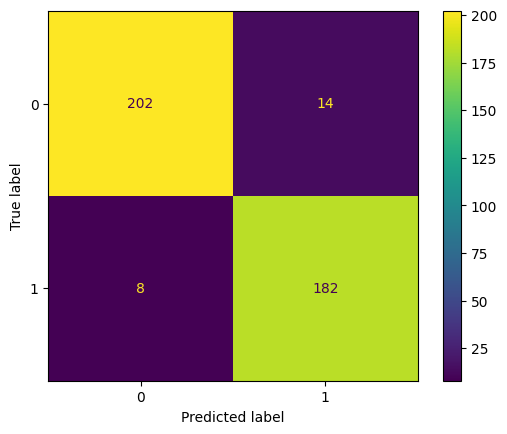

In [75]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [78]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, pos_label='f'), sep='\n')

0.9458128078817734
0.9483568075117371


In [79]:
clf_whg = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf_whg.predict(X_test)
clf_whg.score(X_test, y_test)

Iteration 1, loss = 16.43285330
Iteration 2, loss = 19.38129069
Iteration 3, loss = 16.00493541
Iteration 4, loss = 16.64318235
Iteration 5, loss = 12.19296999
Iteration 6, loss = 11.79725015
Iteration 7, loss = 8.00579359
Iteration 8, loss = 7.37613788
Iteration 9, loss = 5.87769687
Iteration 10, loss = 3.89125121
Iteration 11, loss = 4.35535356
Iteration 12, loss = 5.08573208
Iteration 13, loss = 2.64528073
Iteration 14, loss = 2.30672114
Iteration 15, loss = 1.82222594
Iteration 16, loss = 1.58330724
Iteration 17, loss = 1.73343132
Iteration 18, loss = 1.68344117
Iteration 19, loss = 1.41325331
Iteration 20, loss = 1.75912898
Iteration 21, loss = 1.17154312
Iteration 22, loss = 1.30130554
Iteration 23, loss = 1.61459115
Iteration 24, loss = 1.32585787
Iteration 25, loss = 1.94470269
Iteration 26, loss = 2.07183184
Iteration 27, loss = 1.01474100
Iteration 28, loss = 0.80125829
Iteration 29, loss = 1.68861128
Iteration 30, loss = 2.98505257
Iteration 31, loss = 0.91563730
Iteration 3

0.9679802955665024

In [84]:
X = []
Y = []
for item in tqdm(path2vec_whisper.items()):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_standart[df_standart['filename'] == item[0]]
    target = targets['age_group'].to_list()[0]
    X.append(sum(np.array(vector)))
    Y.append(target)

  0%|          | 0/1228 [00:00<?, ?it/s]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

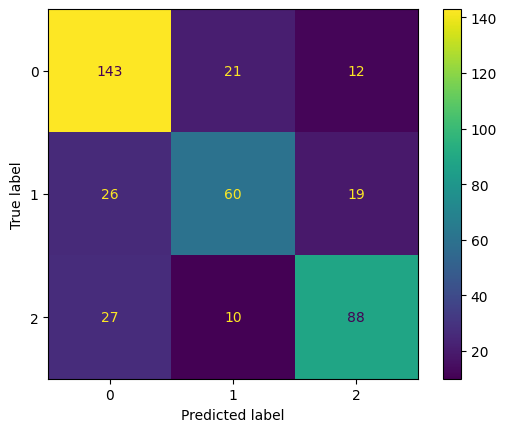

0.7167487684729064
0.7007911925566983


In [71]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

In [90]:
clf_wh = MLPClassifier(hidden_layer_sizes=(256,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf_wh.predict(X_test)
clf_wh.score(X_test, y_test)

Iteration 1, loss = 23.88453638
Iteration 2, loss = 21.91163599
Iteration 3, loss = 20.96575684
Iteration 4, loss = 22.40015901
Iteration 5, loss = 20.11822987
Iteration 6, loss = 19.67167214
Iteration 7, loss = 19.83523913
Iteration 8, loss = 17.27838343
Iteration 9, loss = 17.08610940
Iteration 10, loss = 15.50304364
Iteration 11, loss = 17.74316567
Iteration 12, loss = 18.28883122
Iteration 13, loss = 14.88140232
Iteration 14, loss = 15.58015394
Iteration 15, loss = 14.00952021
Iteration 16, loss = 13.49388787
Iteration 17, loss = 10.17713581
Iteration 18, loss = 10.31109641
Iteration 19, loss = 9.48991131
Iteration 20, loss = 10.08037978
Iteration 21, loss = 9.24291457
Iteration 22, loss = 11.28335522
Iteration 23, loss = 11.66741434
Iteration 24, loss = 9.63035370
Iteration 25, loss = 12.66177144
Iteration 26, loss = 8.73767660
Iteration 27, loss = 8.73261596
Iteration 28, loss = 10.09753694
Iteration 29, loss = 12.58815093
Iteration 30, loss = 8.58564041
Iteration 31, loss = 9.48

0.5714285714285714